# Quora Question Pair Project

The goal of this project is to predict duplicate question pairs. 

The input to the model are two free-text fields, presumably representing two questions.
The ouptut from the model is a binary label, which is 1 if the questions are the same, 0 otherwise. 

## Mounting Google Drive in Colab

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 ## Import required libraries

In [16]:
import numpy as np 
import pandas as pd
import re

import nltk
nltk.download('stopwords')
stops = set(stopwords.words('english'))
from nltk.corpus import stopwords

import datetime
from time import time

from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

import itertools
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding,LSTM,Lambda,Dense
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

from keras import Sequential,backend


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading a TSV Dataset into Pandas

In [14]:
data=pd.read_csv('/content/drive/MyDrive/quora_duplicate_questions.tsv',sep='\t')
data

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


## Data Preprocessing

In [25]:
## Data Preprocessing

def text_to_word_list(text):
    ''' Preprocess and convert texts to a list of words '''
    text = str(text)
    # lowercase
    text = text.lower()
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    # translating abbreviations
    text = re.sub(r"\'re", 'are', text)
    text = re.sub(r"\'ve", 'have', text)
    text = re.sub(r"\'t", 'not', text)
    text = re.sub(r"\'d", 'would', text)
    text = re.sub(r"\'m", 'am', text)
    text = re.sub("where's", 'where is', text)
    text = re.sub("what's", 'what is', text)
    text = re.sub("how's", 'how is', text)
    text = re.sub("who's", 'who is', text)
    text = re.sub("why's", 'why is', text)
    text = re.sub("he's", 'he is', text)
    text = re.sub("it's", 'it is', text)
    text = re.sub("she's", 'she is', text)
    text = re.sub("\'ll", 'will', text)
    text = text.split()

    return text

In [26]:
data.head()

,id,question1,question2,is_duplicate
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [19]:
# Removing unhelpful Columns from our data 
data.drop(['qid1','qid2'],axis=1, inplace=True)


## Loading Pre-trained Word Embeddings (Google News Word2Vec)

In [20]:
import gensim.downloader as api
Embedding_vectors =  api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [27]:
# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  
word2vec = Embedding_vectors 

In [29]:
#list containing the column names of the questions, which are "question1" and "question2"
questions_cols = ["question1", "question2"]

#list containing the indices of the question columns, which are 1 and 2. The indices correspond to the positions of the question columns in the data.
questions_cols_nbs = [1, 2]

for index, row in data.iterrows():
    for question in questions_cols_nbs:

        q2n = []  # q2n -> question numbers representation
        for word in text_to_word_list(row[question]):
            # Check for unwanted words
            if word in stops and word not in word2vec.key_to_index :
                continue
            if word not in vocabulary:
                vocabulary[word] = len(inverse_vocabulary)
                q2n.append(len(inverse_vocabulary))
                inverse_vocabulary.append(word)
            else:
                q2n.append(vocabulary[word])
        # Replace questions as word to question as number representation
        data.iat[index, question] = q2n

the code converts the text questions in the "question1" and "question2" columns of the data into a numerical representation, where each word is replaced with its corresponding index in the vocabulary. This numerical representation can then be used for training a model.

In [30]:
# creating embeding with 300 dimensions 
embedding_dim = 300

embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored
# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.key_to_index:
        embeddings[index] = word2vec.word_vec(word)
        


<ipython-input-30-0e6f4442684a>:8: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embeddings[index] = word2vec.word_vec(word)


In [31]:
data.head()

,id,question1,question2,is_duplicate
0,0,"[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 8, 11]","[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10]",0
1,1,"[1, 2, 3, 12, 13, 14, 15, 16, 17]","[1, 18, 19, 20, 3, 21, 22, 23, 3, 13, 14, 15, ...",0
2,2,"[25, 26, 15, 27, 3, 28, 29, 30, 31, 32, 33, 34]","[25, 26, 30, 28, 35, 36, 5, 37, 38, 39]",0
3,3,"[40, 41, 15, 42, 43, 44, 25, 26, 15, 45, 46]","[47, 3, 48, 49, 50, 51, 52, 50, 2, 53, 5, 52, 51]",0
4,4,"[54, 55, 56, 8, 57, 58, 59, 60, 61, 62, 63, 64]","[54, 65, 18, 66, 8, 60, 57]",0


In [34]:

## find max length of text1 and text2 in both train an text for padding to make the both sentences length equal.
max_seq_length = max(data.question1.map(lambda x: len(x)).max(),
                     data.question2.map(lambda x: len(x)).max())
                    

# Split to train and validation
validation_size = 1000
training_size = len(data) - validation_size

X = data[questions_cols]
Y = data['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}


# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)


assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [35]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 2000
n_epoch = 20


# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32',name='left_input')
right_input = Input(shape=(max_seq_length,), dtype='int32',name='right_name')

# maps input sequences of integers to dense vectors using pre-trained word embeddings
embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# the Lambda layer is used to apply the custom mhd function to the outputs left_output and right_output.
mhd = lambda x: backend.abs(x[0] - x[1])
merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='manhattan_distance')([left_output, right_output])

# sigmoid
# make the final predictions of the model
# 1 indicates that the layer will output a single value
preds = Dense(1, activation='sigmoid')(merged)

# Pack it all up into a model
malstm = Model(inputs=[left_input, right_input],outputs=preds)

#The Adam optimizer adapts the learning rate based on adaptive estimates of first and second moments of the gradients,
#which helps in efficient gradient-based optimization.

malstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

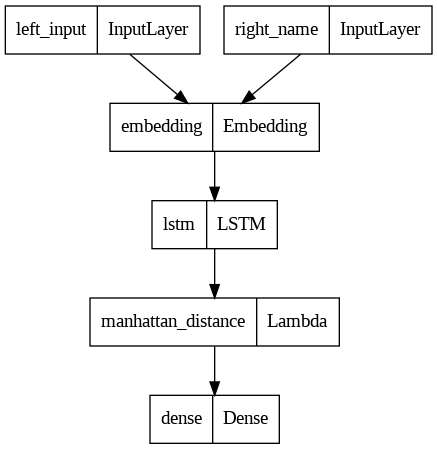

In [36]:
from keras.utils.vis_utils import plot_model
plot_model(malstm)

In [37]:
# Start training
n_epoch = 25
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/25
202/202 [==============================] - 46s 182ms/step - loss: 0.2004 - accuracy: 0.6551 - val_loss: 0.1810 - val_accuracy: 0.7270
Epoch 2/25
202/202 [==============================] - 35s 174ms/step - loss: 0.1684 - accuracy: 0.7494 - val_loss: 0.1616 - val_accuracy: 0.7640
Epoch 3/25
202/202 [==============================] - 36s 179ms/step - loss: 0.1548 - accuracy: 0.7762 - val_loss: 0.1504 - val_accuracy: 0.7790
Epoch 4/25
202/202 [==============================] - 36s 176ms/step - loss: 0.1459 - accuracy: 0.7916 - val_loss: 0.1439 - val_accuracy: 0.7910
Epoch 5/25
202/202 [==============================] - 36s 177ms/step - loss: 0.1392 - accuracy: 0.8034 - val_loss: 0.1395 - val_accuracy: 0.7980
Epoch 6/25
202/202 [==============================] - 36s 176ms/step - loss: 0.1336 - accuracy: 0.8128 - val_loss: 0.1337 - val_accuracy: 0.8010
Epoch 7/25
202/202 [==============================] - 36s 177ms/step - loss: 0.1290 - accuracy: 0.8202 - val_loss: 0.1330 - val_ac

In [41]:
q1 = "What are some effective strategies to enhance my photography skills?"
q2 = "How can I improve my photography skills?"
q3 = "What are the key ingredients for a delicious chocolate cake?"


In [42]:
newdf = pd.DataFrame(np.array([[q1, q2], [q1, q3]]),
                   columns=['qst1', 'qst2'])

text1_preprocess = newdf['qst1'].apply(text_to_word_list)
text2_preprocess = newdf['qst2'].apply(text_to_word_list)

t1v = list()
t2v = list()

for row_text1 in text1_preprocess:
  t1_num = []
  for word in row_text1 :
      if word in vocabulary:
          t1_num.append(vocabulary[word])
  t1v.append(t1_num)

for row_text2 in text2_preprocess:
  t2_num = []
  for word in row_text2: 
    if word in vocabulary:
      t2_num.append(vocabulary[word])
  t2v.append(t2_num)


In [43]:
x_new = pd.DataFrame(zip(t1v, t2v), columns=["qst1", "qst2"])
  # Split to dicts
X_test = {'left': x_new.qst1, 'right': x_new.qst2}
# Zero padding
for dataset, side in itertools.product([X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)
assert X_test['left'].shape == X_test['right'].shape

result = malstm.predict([X_test['left'], X_test['right']])
result

1/1 [==============================] - 0s 23ms/step


array([[0.8265936 ],
       [0.00421833]], dtype=float32)

In [45]:
# Apply threshold for prediction
predictions = [1 if result > 0.5 else 0 for result in result]

print(predictions)

[1, 0]
